In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score as auc 
import seaborn as sns

C:\Users\SATWIK\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SATWIK\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SATWIK\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SATWIK\

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Data Exploration

In [3]:
df = pd.read_csv('creditcard.csv')

In [4]:
df.shape

(284807, 31)

In [5]:
print("Total time spanning: {:.1f} days".format(df['Time'].max() / (3600 * 24.0)))
print("{:.3f} % of all transactions are fraud. ".format(np.sum(df['Class']) / df.shape[0] * 100))

Total time spanning: 2.0 days
0.173 % of all transactions are fraud. 


In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [8]:
df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

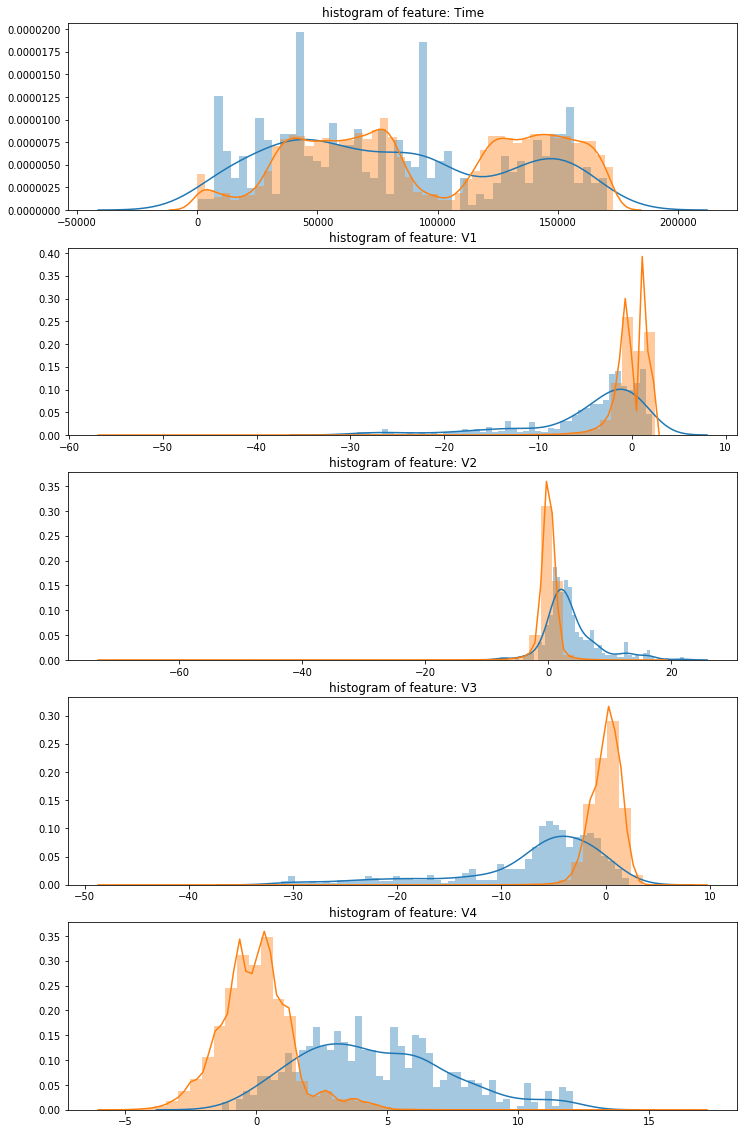

In [9]:
plt.figure(figsize=(12,5*4))
gs = gridspec.GridSpec(5, 1)
for i, cn in enumerate(df.columns[:5]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[cn][df.Class == 1], bins=50)
    sns.distplot(df[cn][df.Class == 0], bins=50)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))
plt.show()

## Train and test split on time series, using first 75% as training/val, and last 25% as test

In [10]:
TEST_RATIO = 0.25
df.sort_values('Time', inplace = True)
TRA_INDEX = int((1-TEST_RATIO) * df.shape[0])
train_x = df.iloc[:TRA_INDEX, 1:-2].values
train_y = df.iloc[:TRA_INDEX, -1].values

test_x = df.iloc[TRA_INDEX:, 1:-2].values
test_y = df.iloc[TRA_INDEX:, -1].values

In [11]:
print("Total train examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(train_x.shape[0], np.sum(train_y), np.sum(train_y)/train_x.shape[0]))

Total train examples: 213605, total fraud cases: 398, equal to 0.00186 of total cases. 


In [12]:
print("Total test examples: {}, total fraud cases: {}, equal to {:.5f} of total cases. ".format(test_x.shape[0], np.sum(test_y), np.sum(test_y)/test_y.shape[0]))

Total test examples: 71202, total fraud cases: 94, equal to 0.00132 of total cases. 


## Feature Normalization - min max score (used for sigmoid activation)

In [13]:
'''cols_max = []
cols_min = []
for c in range(train_x.shape[1]):
    cols_max.append(train_x[:,c].max())
    cols_min.append(train_x[:,c].min())
    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])
    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'''

'cols_max = []\ncols_min = []\nfor c in range(train_x.shape[1]):\n    cols_max.append(train_x[:,c].max())\n    cols_min.append(train_x[:,c].min())\n    train_x[:, c] = (train_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])\n    test_x[:, c] =  (test_x[:, c] - cols_min[-1]) / (cols_max[-1] - cols_min[-1])'

## Feature Normalization 2 - z score (for tanh activation)

In [14]:
cols_mean = []
cols_std = []
for c in range(train_x.shape[1]):
    cols_mean.append(train_x[:,c].mean())
    cols_std.append(train_x[:,c].std())
    train_x[:, c] = (train_x[:, c] - cols_mean[-1]) / cols_std[-1]
    test_x[:, c] =  (test_x[:, c] - cols_mean[-1]) / cols_std[-1]

## Modelling and results


## 1. Auto-encoder as unsupervised learning

### Parameters

In [15]:
# Parameters
learning_rate = 0.001
training_epochs = 10
batch_size = 256
display_step = 1

# Network Parameters
n_hidden_1 = 15 # 1st layer num features
#n_hidden_2 = 15 # 2nd layer num features
n_input = train_x.shape[1] # MNIST data input (img shape: 28*28)
data_dir = '.'

### Train and val the model - (1 hidden layer turned out to be enough)

In [16]:
X = tf.placeholder("float", [None, n_input])

weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    #'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
    #'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    #'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
    #'decoder_b2': tf.Variable(tf.random_normal([n_input])),
}


# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   #biases['encoder_b2']))
    return layer_1


# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.tanh(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    # Decoder Hidden layer with sigmoid activation #2
    #layer_2 = tf.nn.tanh(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                  # biases['decoder_b2']))
    return layer_1

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X

# Define batch mse
batch_mse = tf.reduce_mean(tf.pow(y_true - y_pred, 2), 1)

# Define loss and optimizer, minimize the squared error
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

# TRAIN StARTS
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_x.shape[0], batch_size)
            batch_xs = train_x[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            train_batch_mse = sess.run(batch_mse, feed_dict={X: train_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Train auc=", "{:.6f}".format(auc(train_y, train_batch_mse)), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Instructions for updating:
Colocations handled automatically by placer.
Epoch: 0001 cost= 1.007116675 Train auc= 0.961187 Time elapsed= 0:00:02.640197
Epoch: 0002 cost= 0.843853474 Train auc= 0.957420 Time elapsed= 0:00:06.011051
Epoch: 0003 cost= 0.505903602 Train auc= 0.956186 Time elapsed= 0:00:08.940440
Epoch: 0004 cost= 0.992831349 Train auc= 0.956290 Time elapsed= 0:00:11.204419
Epoch: 0005 cost= 0.457048893 Train auc= 0.956136 Time elapsed= 0:00:13.442249
Epoch: 0006 cost= 0.377180994 Train auc= 0.955996 Time elapsed= 0:00:16.345557
Epoch: 0007 cost= 0.799294353 Train auc= 0.956245 Time elapsed= 0:00:18.261163
Epoch: 0008 cost= 0.391120911 Train auc= 0.956811 Time elapsed= 0:00:20.537436
Epoch: 0009 cost= 0.633314610 Train auc= 0.957458 Time elapsed= 0:00:22.471652
Epoch: 0010 cost= 0.426019698 Train auc= 0.958014 Time elapsed= 0:00:24.416126
Optimization Finished!
Model saved in file: .\temp_saved_model_1layer.ckpt


### Test model - on later 25% test data

In [17]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_batch_mse = sess.run(batch_mse, feed_dict={X: test_x})
    
    print("Test auc score: {:.6f}".format(auc(test_y, test_batch_mse)))
    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from .\temp_saved_model_1layer.ckpt
Test auc score: 0.949464


## Visualize the prediction

### 1. Display fraud score (mse) distribution for non-fraud cases

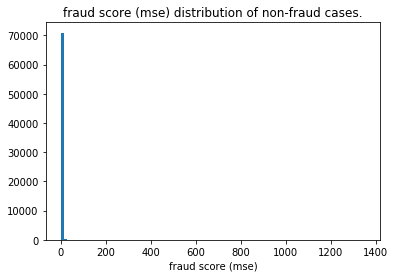

In [18]:
plt.hist(test_batch_mse[test_y == 0.0], bins = 100)
plt.title("fraud score (mse) distribution of non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

### Zoom into (0, 20) range

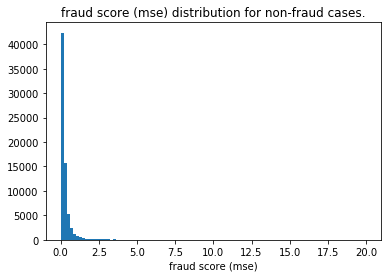

In [19]:
plt.hist(test_batch_mse[(test_y == 0.0) & (test_batch_mse < 20)], bins = 100)
plt.title("fraud score (mse) distribution for non-fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

### 2. Display fraud score (mse) distribution for fraud cases

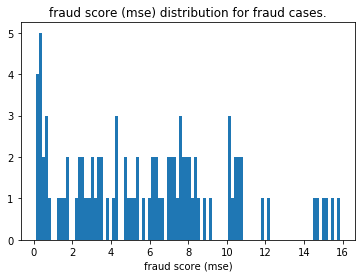

In [20]:
plt.hist(test_batch_mse[test_y == 1.0], bins = 100)
plt.title("fraud score (mse) distribution for fraud cases.")
plt.xlabel("fraud score (mse)")
plt.show()

In [21]:
THRE_TEST = 7
print("Let's, for example, use 7 as our detection threshold: \n\
Number of detected cases above treshold: {}, \n\
Number of pos cases only above threshold: {}, \n\
The percentage of accuracy above treshold (Precision): {:0.2f}%. \n\
Compared to the average percentage of fraud in test set: 0.132%".format( \
np.sum(test_batch_mse > THRE_TEST), \
np.sum(test_y[test_batch_mse > THRE_TEST]), \
np.sum(test_y[test_batch_mse > THRE_TEST]) / np.sum(test_batch_mse > THRE_TEST) * 100))
      

Let's, for example, use 7 as our detection threshold: 
Number of detected cases above treshold: 513, 
Number of pos cases only above threshold: 39, 
The percentage of accuracy above treshold (Precision): 7.60%. 
Compared to the average percentage of fraud in test set: 0.132%


### Observation: Our precision increased by a factor of 60 from 0.132% to 7.86%; However, the detection precision is still low (below 8%), but this is mainly due to the overall percentage of fraud cases is really too low. 

## 2. Build a binary classifier that predicts fraud, using the auto-encoder embedding layers as model inputs. 

### 1) Get auto-encoder embedding (the `encoder_op` tensor) for both train and test data

In [22]:
save_model = os.path.join(data_dir, 'temp_saved_model_1layer.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    saver.restore(sess, save_model)
    
    test_encoding = sess.run(encoder_op, feed_dict={X: test_x})
    train_encoding = sess.run(encoder_op, feed_dict={X: train_x})
    
    print("Dim for test_encoding and train_encoding are: \n", test_encoding.shape, '\n', train_encoding.shape)

INFO:tensorflow:Restoring parameters from .\temp_saved_model_1layer.ckpt
Dim for test_encoding and train_encoding are: 
 (71202, 15) 
 (213605, 15)


### 2) Build the graph for FC layers (best hidden size based on validation is found to be 4)

In [23]:
#n_input = test_encoding.shape[1]
n_input = test_encoding.shape[1]

hidden_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden_size])),
    'b2': tf.Variable(tf.zeros([output_size])),
}

hidden_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
pred_logits = tf.add(tf.matmul(hidden_layer, weights['W2']), biases['b2'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(2e-4).minimize(cross_entropy)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### 3) Prepare the data set. 
### Now we need to re-split the train into train/val, due to supervised training.
### We will therefore use 80% of out previous training data as our new training, and the remaining 20% as new validation. (train : val : test = (0.75x0.8) : (0.75x0.2) : (0.25x1.0)). 
### Finally we start to train our binary classifier

In [24]:
n_epochs = 80
batch_size = 256

# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_encoding[:int(train_encoding.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_encoding.shape[0] * (1-VAL_PERC))]

val_enc_x = train_encoding[int(train_encoding.shape[0] * (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_encoding.shape[0]]

test_enc_y = all_y_bin[train_encoding.shape[0]:]
print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))

# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]

            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 1.171021938 Val auc= 0.795804 Time elapsed= 0:00:01.144214
Epoch: 0002 cost= 0.764427483 Val auc= 0.841869 Time elapsed= 0:00:02.024942
Epoch: 0003 cost= 0.377719253 Val auc= 0.873507 Time elapsed= 0:00:02.865733
Epoch: 0004 cost= 0.277383447 Val auc= 0.880254 Time elapsed= 0:00:03.703116
Epoch: 0005 cost= 0.170312434 Val auc= 0.885997 Time elapsed= 0:00:04.554053
Epoch: 0006 cost= 0.107626125 Val auc= 0.891862 Time elapsed= 0:00:05.410227
Epoch: 0007 cost= 0.060883403 Val auc= 0.895428 Time elapsed= 0:00:06.343502
Epoch: 0008 cost= 0.048092753 Val auc= 0.898858 Time elapsed= 0:00:07.170855
Epoch: 0009 cost= 0.023933368 Val auc= 0.903194 Time elapsed= 0:00:08.014578
Epoch: 0010 cost= 0.015376372 Val auc= 0.905436 Time elapsed= 0:00:08.851122
Epoch: 0011 cost= 0.013529419 Val auc= 0.907147 Time elapsed= 0:00:09.699617
Epoch: 0012 cost= 0.005654117 Val auc= 0.908800 Time elapsed= 0:00:10.541152
Epoch: 0013

### 4) Test the model on the same test data as before - improved on AUC slightly - 0.9669

In [25]:
save_model = os.path.join(data_dir, 'temp_saved_model_FCLayers.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_probs = sess.run(pred_probs, feed_dict={X: test_encoding})
    
    print("\nTest auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))

INFO:tensorflow:Restoring parameters from .\temp_saved_model_FCLayers.ckpt

Test auc score: 0.9639581804842259


## 3. (Optional) However, let's test a simple supervisied neural network (two layers FC) from scratch - without using auto-encoder

### 1) Build graph - 28 (input) -> 8 -> 4 -> 2

In [26]:
n_epochs = 200
batch_size = 256

#n_input = test_encoding.shape[1]
n_input = train_x.shape[1]

hidden1_size = 8
hidden2_size = 4
output_size = 2

X = tf.placeholder(tf.float32, [None, n_input], name='input_x')
y_ = tf.placeholder(tf.int32, shape=[None, output_size], name='target_y')

weights = {
    'W1': tf.Variable(tf.truncated_normal([n_input, hidden1_size])),
    'W2': tf.Variable(tf.truncated_normal([hidden1_size, hidden2_size])),
    'W3': tf.Variable(tf.truncated_normal([hidden2_size, output_size])),
}
biases = {
    'b1': tf.Variable(tf.zeros([hidden1_size])),
    'b2': tf.Variable(tf.zeros([hidden2_size])),
    'b3': tf.Variable(tf.zeros([output_size])),
}

hidden1_layer =  tf.nn.relu(tf.add(tf.matmul(X, weights['W1']), biases['b1']))
hidden2_layer =  tf.nn.relu(tf.add(tf.matmul(hidden1_layer, weights['W2']), biases['b2']))
pred_logits = tf.add(tf.matmul(hidden2_layer, weights['W3']), biases['b3'])
pred_probs = tf.nn.softmax(pred_logits)

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=pred_logits))

optimizer = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)


### 2) Prepare the data set. Now we need to re-split the train into train/val. 
### Again, we will use 80% of out previous training data as our new training, and the remaining 20% as new validation. (train : val : test = (0.75x0.8) : (0.75x0.2) : (0.25x1.0)).


In [27]:
# PREPARE DATA
VAL_PERC = 0.2
all_y_bin = np.zeros((df.shape[0], 2))
all_y_bin[range(df.shape[0]), df['Class'].values] = 1

train_enc_x = train_x[:int(train_x.shape[0] * (1-VAL_PERC))]
train_enc_y = all_y_bin[:int(train_x.shape[0] * (1-VAL_PERC))]

val_enc_x = train_x[int(train_encoding.shape[0] *  (1-VAL_PERC)):]
val_enc_y = all_y_bin[int(train_encoding.shape[0] * (1-VAL_PERC)):train_x.shape[0]]

test_enc_y = all_y_bin[train_x.shape[0]:]

print("Num of data for train, val and test are: \n{}, \n{}, \n{}".format(train_enc_x.shape[0], val_enc_x.shape[0], \
                                                                        test_encoding.shape[0]))
# TRAIN STARTS
save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
saver = tf.train.Saver()

# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    sess.run(init)
    total_batch = int(train_enc_x.shape[0]/batch_size)
    # Training cycle
    for epoch in range(n_epochs):
        # Loop over all batches
        for i in range(total_batch):
            batch_idx = np.random.choice(train_enc_x.shape[0], batch_size)
            batch_xs = train_enc_x[batch_idx]
            batch_ys = train_enc_y[batch_idx]
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cross_entropy], feed_dict={X: batch_xs, y_: batch_ys})
            
        # Display logs per epoch step
        if epoch % display_step == 0:
            val_probs = sess.run(pred_probs, feed_dict={X: val_enc_x})
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c), 
                  "Val auc=", "{:.6f}".format(auc(val_enc_y[:, 1], val_probs[:, 1])), 
                  "Time elapsed=", "{}".format(datetime.now() - now))

    print("Optimization Finished!")
    
    save_path = saver.save(sess, save_model)
    print("Model saved in file: %s" % save_path)
    

Num of data for train, val and test are: 
170884, 
42721, 
71202
Epoch: 0001 cost= 9.266540527 Val auc= 0.736478 Time elapsed= 0:00:01.434330
Epoch: 0002 cost= 6.097185135 Val auc= 0.757670 Time elapsed= 0:00:02.546774
Epoch: 0003 cost= 2.856737137 Val auc= 0.759433 Time elapsed= 0:00:03.707811
Epoch: 0004 cost= 1.106646061 Val auc= 0.752645 Time elapsed= 0:00:04.873973
Epoch: 0005 cost= 0.757975936 Val auc= 0.754369 Time elapsed= 0:00:06.095302
Epoch: 0006 cost= 0.424908400 Val auc= 0.755209 Time elapsed= 0:00:07.750583
Epoch: 0007 cost= 0.201498836 Val auc= 0.753311 Time elapsed= 0:00:08.968400
Epoch: 0008 cost= 0.128369376 Val auc= 0.749879 Time elapsed= 0:00:10.089220
Epoch: 0009 cost= 0.125300288 Val auc= 0.743932 Time elapsed= 0:00:11.277344
Epoch: 0010 cost= 0.082175866 Val auc= 0.739528 Time elapsed= 0:00:12.494696
Epoch: 0011 cost= 0.059744820 Val auc= 0.737702 Time elapsed= 0:00:13.829092
Epoch: 0012 cost= 0.041654713 Val auc= 0.734569 Time elapsed= 0:00:15.045090
Epoch: 0013

### 3) Predict on test data

In [28]:
save_model = os.path.join(data_dir, 'temp_saved_model_FCNNets_raw.ckpt')
saver = tf.train.Saver()
# Initializing the variables
init = tf.global_variables_initializer()

with tf.Session() as sess:
    now = datetime.now()
    
    saver.restore(sess, save_model)
    
    test_probs = sess.run(pred_probs, feed_dict={X: test_x})
    
    print("Test auc score: {}".format(auc(test_enc_y[:, 1], test_probs[:, 1])))

INFO:tensorflow:Restoring parameters from .\temp_saved_model_FCNNets_raw.ckpt
Test auc score: 0.9429046496848066
